In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
from utils import extract_dataset
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

dataset_file_path = extract_dataset('GlobalTerrorismDataset.zip')
df = pd.read_csv(dataset_file_path, encoding='ISO-8859-1', low_memory=False)

selected_columns = [
    'iyear', 'imonth', 'iday', 'extended', 'resolution', 'country_txt', 
    'region_txt', 'city', 'success', 'suicide', 'attacktype1_txt', 
    'targtype1_txt', 'natlty1_txt', 'gname', 'nperps', 'weaptype1_txt', 
    'nkill', 'nwound', 'nkillus', 'nwoundus', 'dbsource'
]

filtered_df = df[selected_columns]

column_renaming = {
    'iyear': 'Year', 'imonth': 'Month', 'iday': 'Day', 'extended': 'Extended', 
    'resolution': 'Resolution', 'country_txt': 'Country', 'region_txt': 'Region', 
    'city': 'City', 'success': 'Success', 'suicide': 'Suicide', 
    'attacktype1_txt': 'Attack Type', 'targtype1_txt': 'Target Type', 
    'natlty1_txt': 'Target Nationality', 'gname': 'Attacking Group Name', 
    'nperps': 'Number of Terrorists', 'weaptype1_txt': 'Weapon Type', 
    'nkill': 'Number of Killed People', 'nwound': 'Number of Wounded People', 
    'nkillus': 'Number of Killed US People', 'nwoundus': 'Number of Wounded US People', 
    'dbsource': 'Database Source'
}

filtered_df = filtered_df.rename(columns=column_renaming)

def is_valid_date(year, month, day):
    """Check if the given year, month, day form a valid date."""
    try:
        datetime(year, month, day)
        return True
    except ValueError:
        return False

def calculate_duration(row):
    if not is_valid_date(row['Year'], row['Month'], row['Day']):
        return 0
    
    if row['Extended'] == 1 and pd.notnull(row['Resolution']):
        attack_date = datetime(row['Year'], row['Month'], row['Day'])
        try:
            resolution_date = datetime.strptime(row['Resolution'], "%m/%d/%Y")
            return (resolution_date - attack_date).days
        except ValueError:
            return 1
    return 1

filtered_df['Duration'] = filtered_df.apply(calculate_duration, axis=1)
filtered_df = filtered_df.drop(columns=['Extended', 'Resolution'])

def calculate_casualties(row):
    if pd.isnull(row['Number of Killed People']) or pd.isnull(row['Number of Wounded People']):
        return -99
    return row['Number of Killed People'] + row['Number of Wounded People']

filtered_df['Number of Casualties'] = filtered_df.apply(calculate_casualties, axis=1)

# Replace null values with -99
filtered_df['Number of Terrorists'] = filtered_df['Number of Terrorists'].fillna(-99)
filtered_df['Number of Killed People'] = filtered_df['Number of Killed People'].fillna(-99)
filtered_df['Number of Wounded People'] = filtered_df['Number of Wounded People'].fillna(-99)
filtered_df['Number of Killed US People'] = filtered_df['Number of Killed US People'].fillna(-99)
filtered_df['Number of Wounded US People'] = filtered_df['Number of Wounded US People'].fillna(-99)
filtered_df['Target Nationality'] = filtered_df['Target Nationality'].fillna('Unknown')

globalterrorismdb_0718dist.csv already exists!


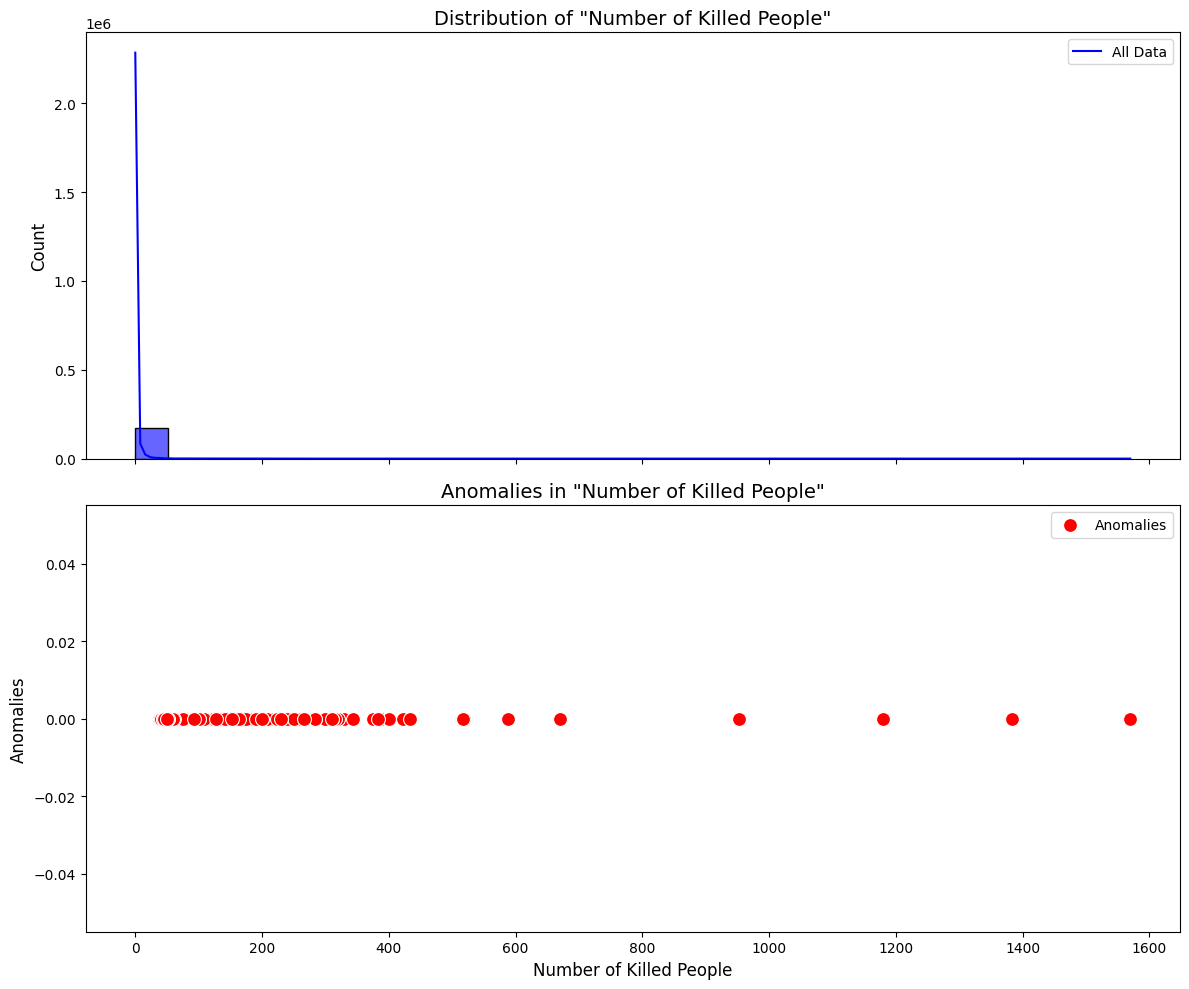

In [2]:
# Statistical anomaly detection function
def statistical_anomaly_detection_z_score(data, column, threshold=3):
    valid_data = data[data[column] != -99].copy()
    
    mean = valid_data[column].mean()
    std = valid_data[column].std()
    valid_data['Z Score'] = (valid_data[column] - mean) / std
    
    anomalies = valid_data[np.abs(valid_data['Z Score']) > threshold]
    return anomalies

filtered_df = filtered_df[filtered_df['Number of Killed People'] != -99].copy()

stat_anomalies_killed = statistical_anomaly_detection_z_score(filtered_df, 'Number of Killed People')

fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
sns.histplot(
    filtered_df['Number of Killed People'],
    bins=30,
    kde=True,
    color='blue',
    alpha=0.6,
    ax=ax[0]
)
ax[0].set_title('Distribution of "Number of Killed People"', fontsize=14)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].legend(['All Data'], fontsize=10)

sns.scatterplot(
    data=stat_anomalies_killed,
    x='Number of Killed People',
    y=[0] * len(stat_anomalies_killed),
    color='red',
    s=100,
    ax=ax[1]
)
ax[1].set_title('Anomalies in "Number of Killed People"', fontsize=14)
ax[1].set_xlabel('Number of Killed People', fontsize=12)
ax[1].set_ylabel('Anomalies', fontsize=12)
ax[1].legend(['Anomalies'], fontsize=10)

plt.tight_layout()
plt.show()


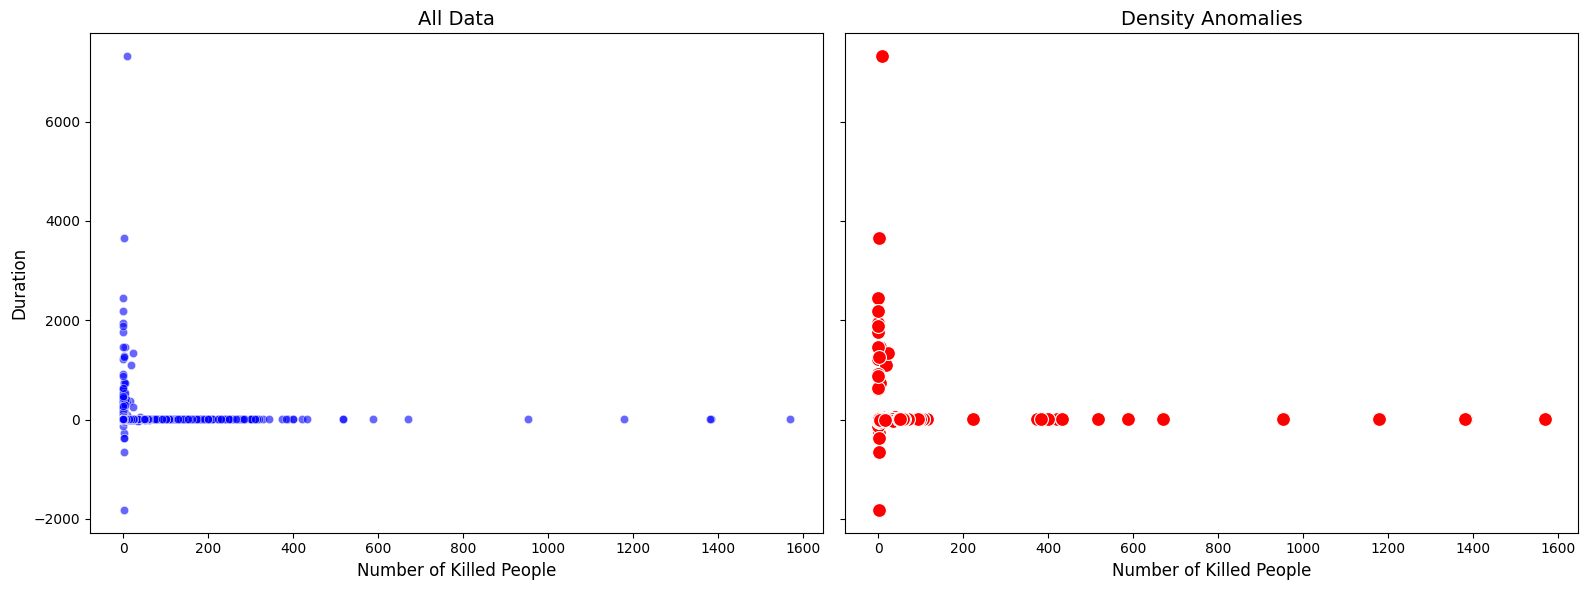

In [3]:
def density_based_anomaly_detection(data, columns, n_neighbors=20):
    valid_data = data[(data[columns] != -99).all(axis=1)][columns].dropna().copy()
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, metric='euclidean')
    valid_data['density_score'] = lof.fit_predict(valid_data)
    valid_data['Anomaly Score'] = -lof.negative_outlier_factor_

    anomalies = valid_data[valid_data['density_score'] == -1].copy()

    data['Anomaly Type'] = 'Normal'  # Default to normal
    data.loc[anomalies.index, 'Anomaly Type'] = 'Density Anomaly'

    return anomalies

density_combo = ['Number of Killed People', 'Duration']
density_anomalies = density_based_anomaly_detection(filtered_df, density_combo)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.scatterplot(
    data=filtered_df,
    x='Number of Killed People',
    y='Duration',
    color='blue',
    alpha=0.6,
    ax=ax[0]
)
ax[0].set_title('All Data', fontsize=14)
ax[0].set_xlabel('Number of Killed People', fontsize=12)
ax[0].set_ylabel('Duration', fontsize=12)

sns.scatterplot(
    data=density_anomalies,
    x='Number of Killed People',
    y='Duration',
    color='red',
    s=100,
    ax=ax[1]
)
ax[1].set_title('Density Anomalies', fontsize=14)
ax[1].set_xlabel('Number of Killed People', fontsize=12)

plt.tight_layout()
plt.show()


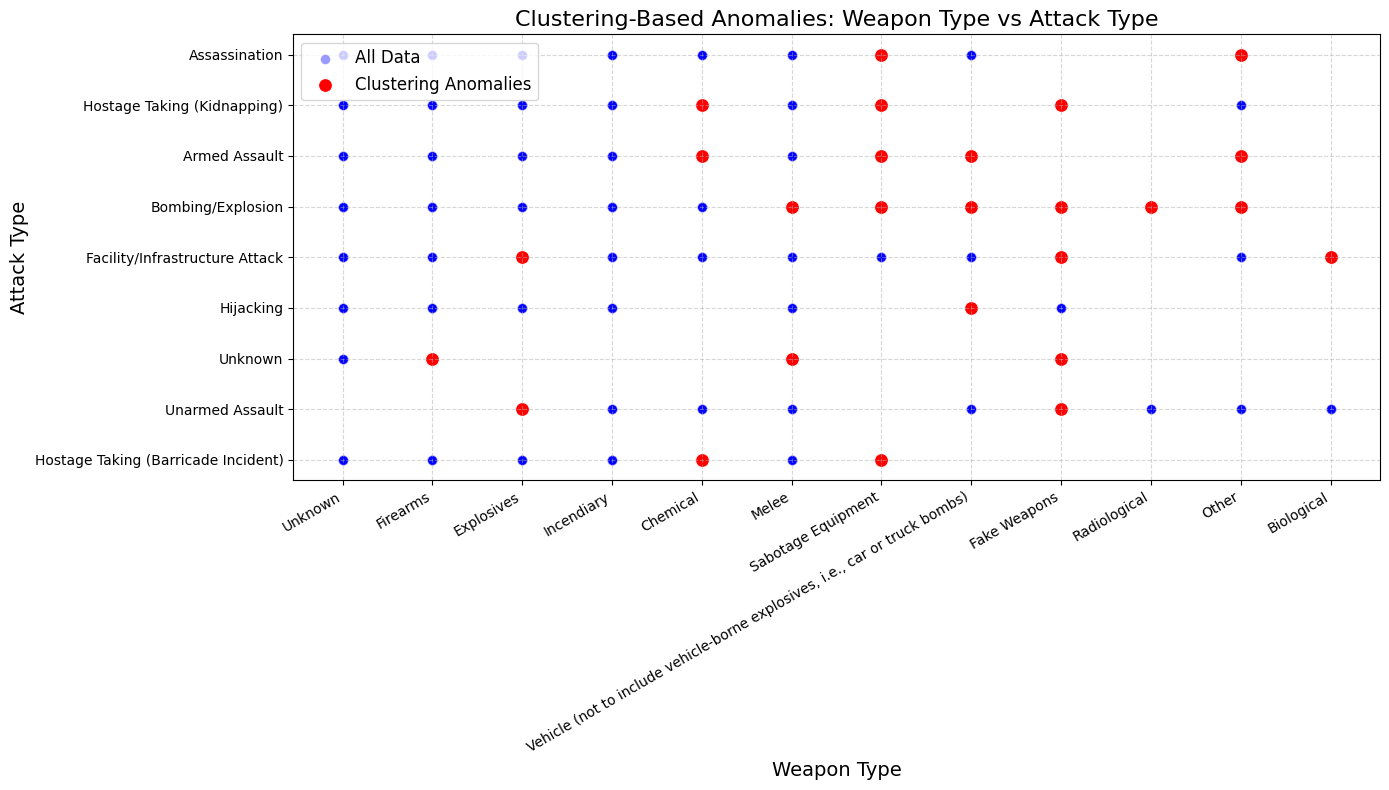

In [4]:
def clustering_based_anomaly_detection(data, columns, eps=0.8, min_samples=10):
    for col in ['Year', 'Country', 'Weapon Type', 'Attack Type']:
        if col not in data.columns:
            data[col] = '-'
    
    available_columns = [col for col in columns if col in data.columns]   
    valid_data = pd.get_dummies(data[available_columns].dropna())
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    valid_data['cluster'] = dbscan.fit_predict(valid_data)
    
    anomalies = valid_data[valid_data['cluster'] == -1].copy()
    
    for col in ['Year', 'Country', 'Weapon Type', 'Attack Type']:
        anomalies[col] = data.loc[anomalies.index, col]
    
    anomalies['Anomaly Score'] = 1     
    anomaly_percentage = (len(anomalies) / len(valid_data)) * 100
    
    return anomalies

clustering_combo = ['Weapon Type', 'Attack Type']
cluster_anomalies = clustering_based_anomaly_detection(filtered_df, clustering_combo)

plt.figure(figsize=(14, 8))

sns.scatterplot(
    data=filtered_df, 
    x='Weapon Type', 
    y='Attack Type', 
    label='All Data', 
    color='blue', 
    alpha=0.4, 
    s=50, 
    marker='o'
)

sns.scatterplot(
    data=cluster_anomalies, 
    x='Weapon Type', 
    y='Attack Type', 
    label='Clustering Anomalies', 
    color='red', 
    s=100, 
    marker='o'
)

plt.xticks(
    rotation=30, 
    ha='right',   
    fontsize=10   
)

plt.title('Clustering-Based Anomalies: Weapon Type vs Attack Type', fontsize=16)
plt.xlabel('Weapon Type', fontsize=14)
plt.ylabel('Attack Type', fontsize=14)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

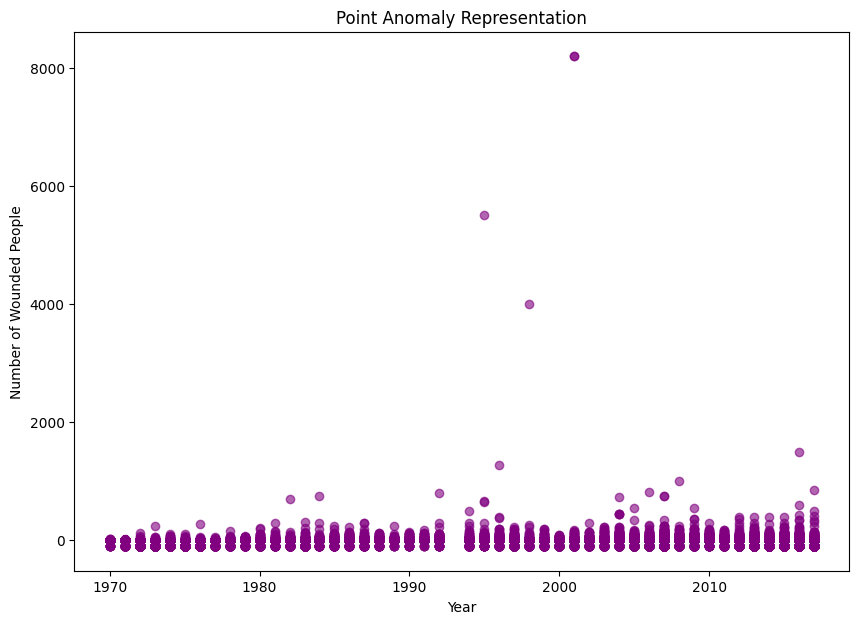

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

plt.scatter(
    x=filtered_df['Year'],
    y=filtered_df['Number of Wounded People'],
    alpha=0.6,
    color='purple'
)

plt.xlabel('Year')
plt.ylabel('Number of Wounded People')
plt.title('Point Anomaly Representation')
plt.show()
